In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iterativeClustering import clusterings_with_hors, bfs_merge
from cluster import build_seqs_distance_matrix, distance_values, get_seq_as_txt
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation 
from Bio import Phylo
from showHOR import show_hor, show_hors, show_hor_tree
from featureUtils import BED_file_to_features, feature_to_seq
from treeFromClusters import new_phyloXML


In [2]:
references = {seq.id : seq for seq in SeqIO.parse("./data/monomers/chr2_centromere_plus2Mb.fasta", "fasta")}

In [3]:
monomers_as_features = BED_file_to_features("./data/monomers/chr2_StringDecMon2extr_noMorgante.bed")

In [4]:
monomers_as_features[0]

SeqFeature(SimpleLocation(ExactPosition(1916940), ExactPosition(1917047), strand=-1, ref='chr2:10940332-15983263'), type='repeat', id='chr2:12857272-12857379', ref='chr2:10940332-15983263')

In [5]:
[(feature.location.start, feature.__len__()) for feature in monomers_as_features if feature.__len__() < 70]

[(ExactPosition(1985104), 60),
 (ExactPosition(2373213), 58),
 (ExactPosition(2380415), 59),
 (ExactPosition(2482806), 60),
 (ExactPosition(2488408), 60),
 (ExactPosition(2723085), 60),
 (ExactPosition(2746370), 68),
 (ExactPosition(3014699), 55)]

In [6]:
# sample monomers for testing purposes (comment out for complete analysis)

sample_size = 60
num_samples = 5

sample_page = len(monomers_as_features) // num_samples
sample_offset = (sample_page - sample_size) // 2

def slice_seq(seq, position, length):
    return seq[position : position + length]

monomers_as_features = [
    monomer
    for sample_index in range(num_samples)
    for monomer in slice_seq(monomers_as_features, sample_index * sample_page + sample_offset, sample_size)
]

In [7]:
monomers_as_seqs = [feature_to_seq(feature, references) for feature in monomers_as_features]

In [8]:
monomer_dists = build_seqs_distance_matrix(monomers_as_seqs)

In [9]:
def max_len(strings):
    return max([len(s) for s in strings])

(array([2.800e+02, 2.890e+02, 2.850e+02, 3.080e+02, 2.700e+02, 2.850e+02,
        3.780e+02, 5.220e+02, 5.770e+02, 6.030e+02, 5.810e+02, 6.930e+02,
        7.510e+02, 8.220e+02, 8.190e+02, 1.038e+03, 9.040e+02, 9.120e+02,
        8.800e+02, 7.540e+02, 5.940e+02, 4.850e+02, 4.430e+02, 2.510e+02,
        1.770e+02, 2.120e+02, 1.640e+02, 2.840e+02, 3.700e+02, 5.970e+02,
        7.020e+02, 7.130e+02, 7.990e+02, 9.940e+02, 8.060e+02, 8.400e+02,
        8.020e+02, 1.154e+03, 1.649e+03, 2.235e+03, 2.988e+03, 2.976e+03,
        2.668e+03, 2.032e+03, 2.077e+03, 1.734e+03, 1.330e+03, 9.290e+02,
        6.180e+02, 3.390e+02, 3.210e+02, 1.700e+02, 1.350e+02, 1.250e+02,
        6.000e+01, 3.200e+01, 2.800e+01, 2.300e+01, 1.300e+01, 2.100e+01,
        5.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36

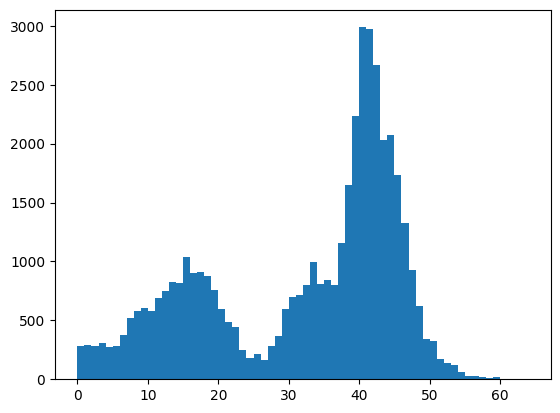

In [10]:
dist_values = distance_values(monomer_dists)
plt.hist(dist_values, bins=int(max(dist_values)))


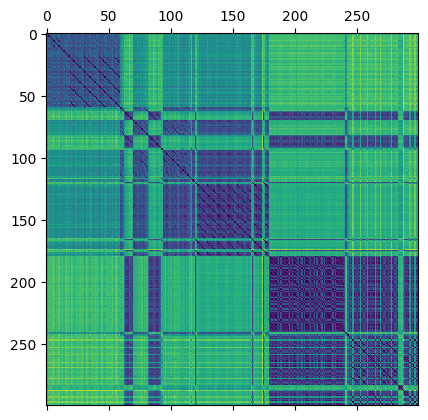

In [11]:
plt.matshow(monomer_dists)

In [12]:
clusterings, tree, hors, hor_tree_root = clusterings_with_hors(monomers_as_seqs, seqs_as_features=monomers_as_features, distance_matrix=monomer_dists, min_len_loop=1, min_loop_reps=3)

Start of clusterings_with_hors
merge_clusters with distance as (300, 300), clusters as (), and max distance 0
adjacency matrix sparsity is 0.9904444444444445
merge_clusters with distance as (172, 172), clusters as (172, 300), and max distance 1
adjacency matrix sparsity is 0.9915494862087615
merge_clusters with distance as (134, 134), clusters as (134, 300), and max distance 2
adjacency matrix sparsity is 0.990198262419247
merge_clusters with distance as (114, 114), clusters as (114, 300), and max distance 3
adjacency matrix sparsity is 0.9899969221298861
merge_clusters with distance as (106, 106), clusters as (106, 300), and max distance 4
adjacency matrix sparsity is 0.9884300462798149
merge_clusters with distance as (94, 94), clusters as (94, 300), and max distance 5
adjacency matrix sparsity is 0.9864191942055228
merge_clusters with distance as (81, 81), clusters as (81, 300), and max distance 6
adjacency matrix sparsity is 0.9839963420210334
Looking for loops in Num clusters: 69, 

In [13]:
[
    [str(loop)
    for loop in clustering.loops]
    for clustering in clusterings
]

[['AAQAZAaQ in [62:103]'],
 ['hijklmnopqrs in [240:281]'],
 ['abcdefghijck in [240:281]'],
 ['WXXYXZabcdXe in [240:281]'],
 ['A in [0:3],[10:22],[34:57],[62:68],[69:76],[77:84],[85:92],[93:100],[101:105],[108:114],[117:120]',
  'AAAAAAIA in [62:105]',
  'P in [240:243],[252:255],[264:267],[276:279]',
  'PPPQPRSTUPPU in [240:281]'],
 ['LLLMLNOLMLLM in [240:281]'],
 ['LLLMLLNLMLLM in [240:282]'],
 ['K in [240:246],[247:258],[259:270],[271:289],[290:293],[294:300]',
  'KKKKKKLKKKKK in [240:282]'],
 ['A in [0:3],[10:22],[34:57],[62:105],[108:114],[117:120]', 'I in [240:300]'],
 ['A in [0:3],[10:22],[34:57],[62:105],[108:115],[117:120],[240:300]',
  'B in [3:10],[22:33],[120:180],[183:187],[188:193],[194:199],[200:205],[206:209],[210:218],[219:224],[228:233],[234:237]'],
 ['A in [0:60],[60:120],[120:180],[180:187],[188:193],[194:199],[200:205],[206:209],[210:218],[219:224],[228:233],[234:237],[240:300]',
  'AAAAAB in [182:209]',
  'B in [224:228]'],
 ['A in [0:60],[60:120],[120:180],[180:24

In [14]:
[
    str(clustering)
    for clustering in clusterings
]

["Num clusters: 69, Seqs: ['ABCDEFFGHIJAABCABKLABCDEFFGHIFFMNOABKAABPABKLABCQRSQRAATCUVW', 'XYAAQAZAaQAAQAZAaQAAQAZAaQAAQAZAaQAAQAZAaQAZAbXYAAQAZAcXYAAQ', 'dFFFFFFdFdFFFFFFdFdFFFFdFFdFdFFFFdFFdFdFFFdFdFFFFFFdFdFFFFFF', 'efghFiFjFFFdFjFFdkFjFiFiFjFiFjFFdkFFdFjFFdkFlmlmniFiFjFiFjFF', 'opqrstuvwxyzopqrstuvwxyzopqrstuvwxyzopqrs*******************'], Loops: ['AAQAZAaQ in [62:103]']",
 "Num clusters: 62, Seqs: ['ABCDEFFGHIAAABCABJKABCDEFFGHIFFLMNABJAABCABJKABCAAOAAAABCPJQ', 'RSAAAAAATAAAAAAATAAAAAAATAAAAAAATAAAAAAATAAAAURSAAAAAAVRSAAA', 'WFFFFFFWFWFFFFFFWFWFFFFWFFWFWFFFFWFFWFWFFFWFWFFFFFFWFWFFFFFF', 'XYZaFbFcFFFWFcFFWdFcFbFbFcFbFcFFWdFFWFcFFWdFefefgbFbFcFbFcFF', 'hijklmnopqrshijklmnopqrshijklmnopqrshijkltuvwxyz************'], Loops: ['hijklmnopqrs in [240:281]']",
 "Num clusters: 51, Seqs: ['ABCDEEEFGEAAABCABHIABCDEEEFGEEEJKLABHAABCABHIABCAACAAAABCMHA', 'NOAAAAAAPAAAAAAAPAAAAAAAPAAAAAAAPAAAAAAAPAAAAQNOAAAAAARNOAAA', 'NEEEEEENENEEEEEENENEEEENEENENEEEENEENENEEENENEEEEEENENEEEEEE', 'STUVENEWEEE

Subtree: []
None


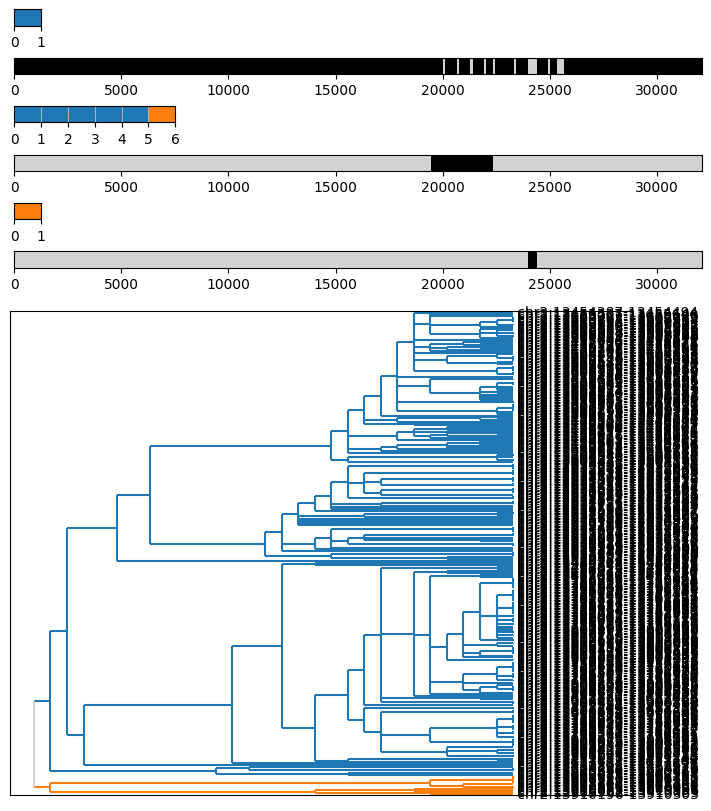

Subtree: [0]
None


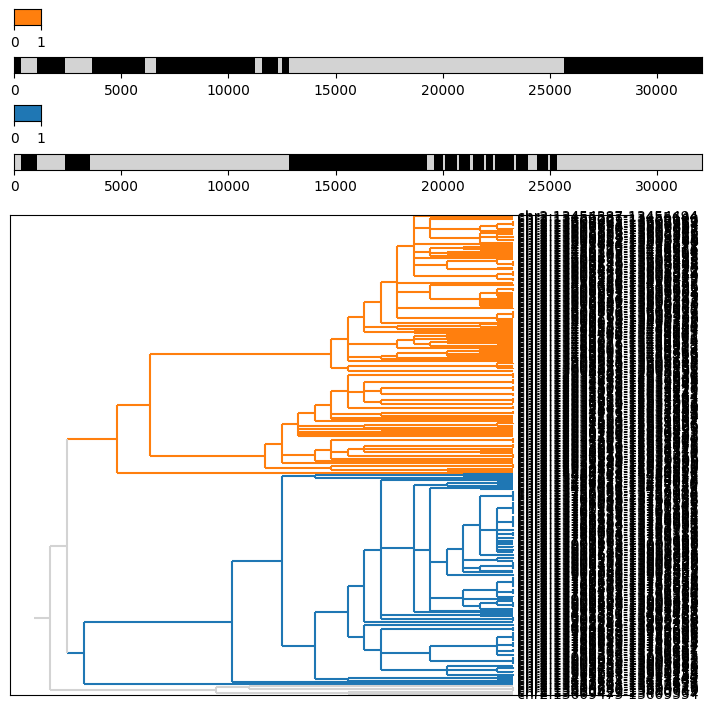

Subtree: [0, 0]
None


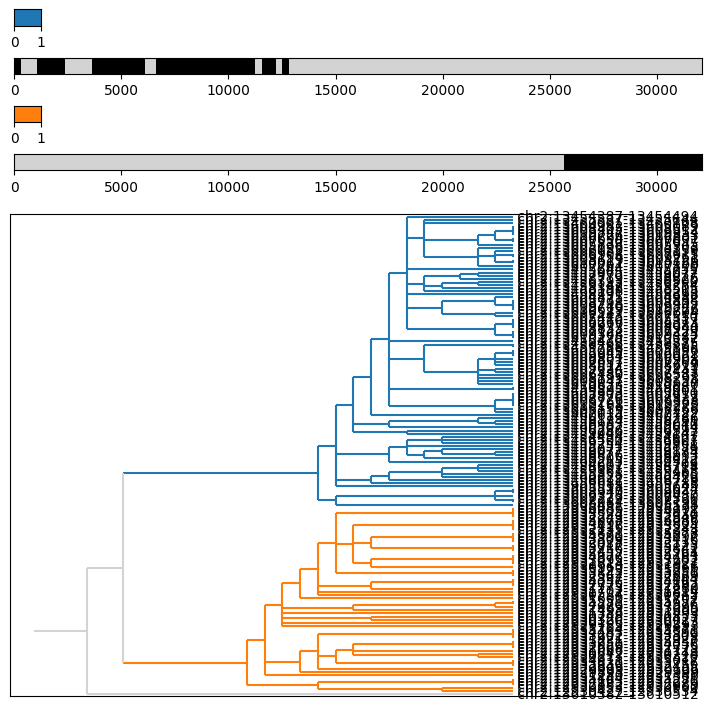

Subtree: [0, 0, 0]
None


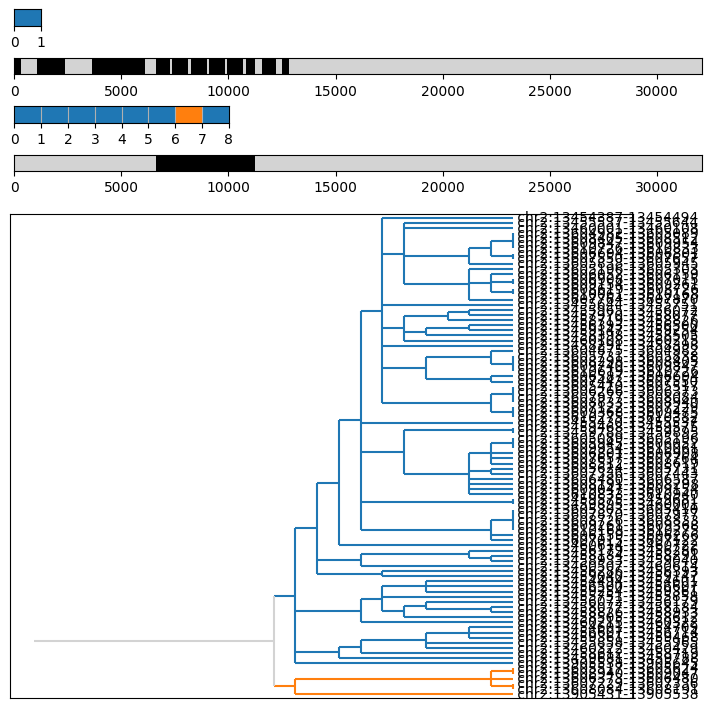

Subtree: [0, 0, 0, 1]
None


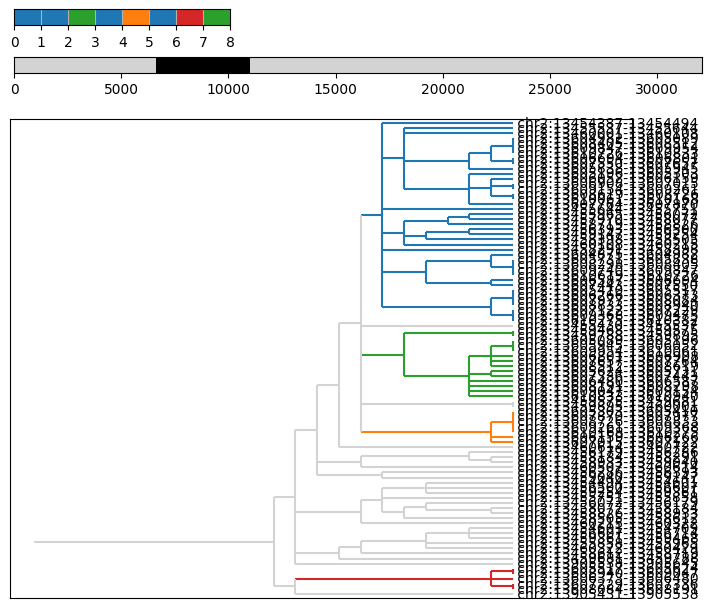

Subtree: [0, 0, 1]
None


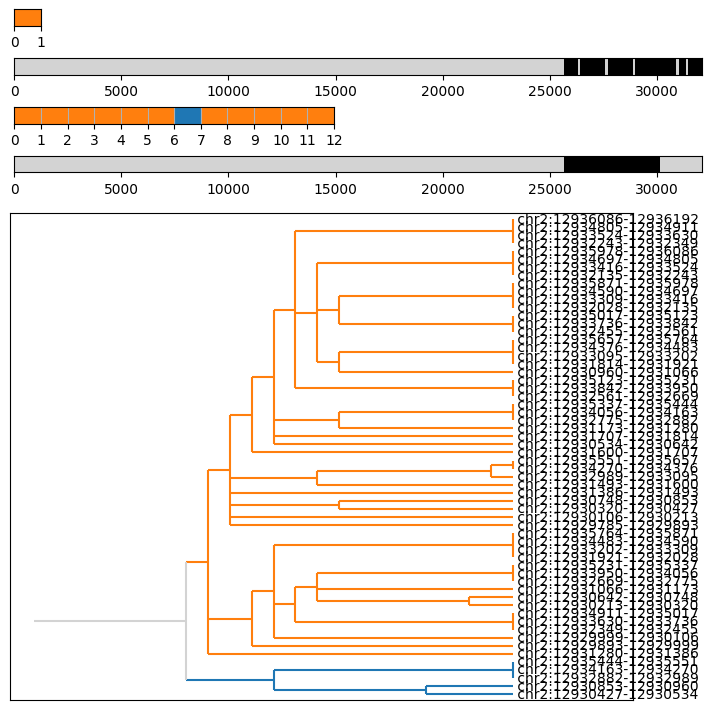

Subtree: [0, 0, 1, 1]
None


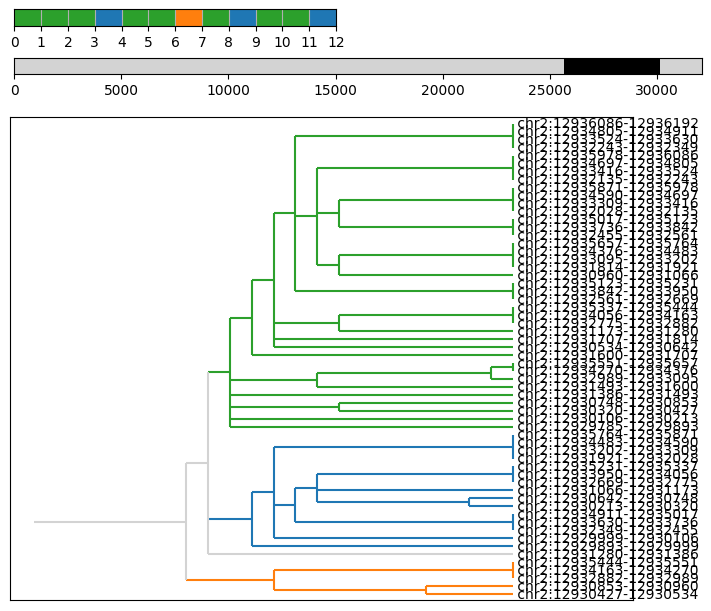

Subtree: [0, 0, 1, 1, 0]
None


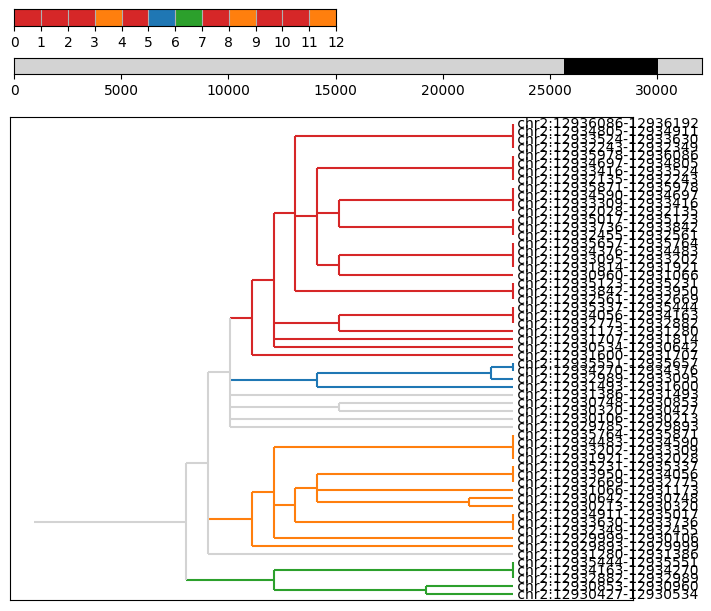

Subtree: [0, 0, 1, 1, 0, 0]
None


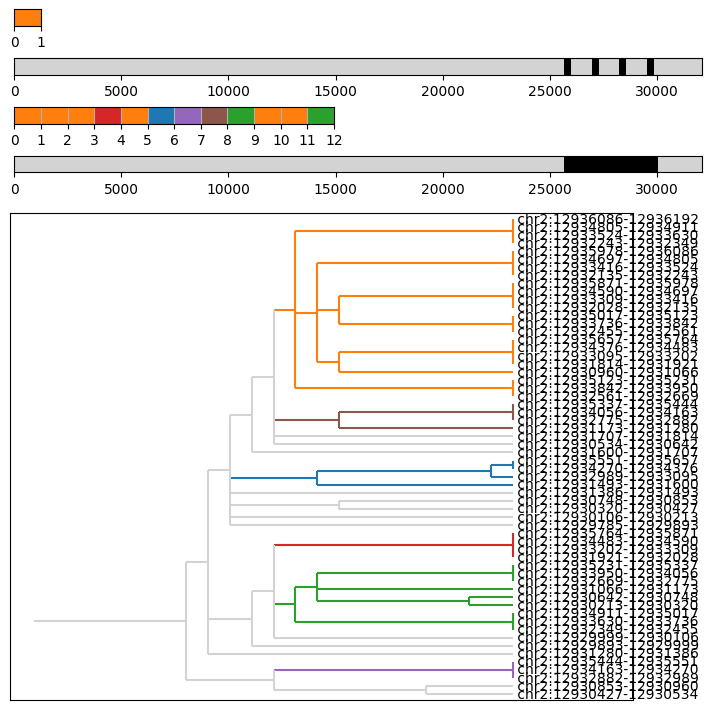

Subtree: [0, 0, 1, 1, 0, 0, 1]
None


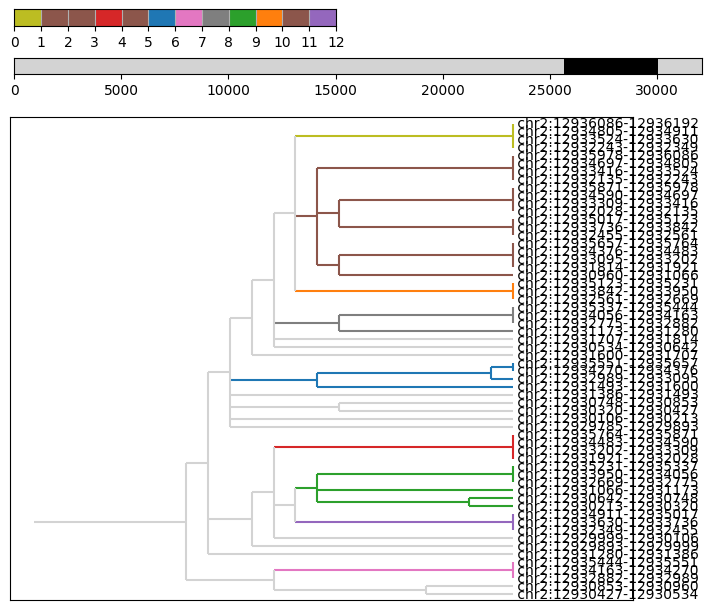

Subtree: [0, 0, 1, 1, 0, 0, 1, 0]
None


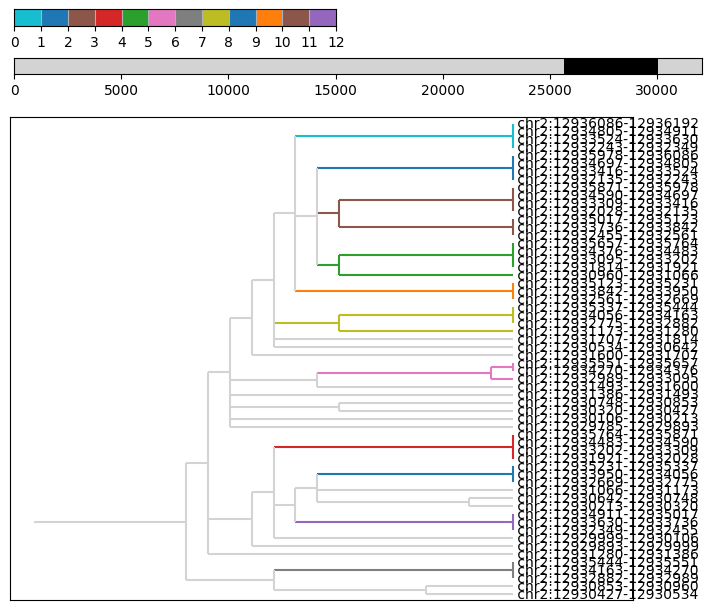

Subtree: [0, 0, 1, 1, 0, 0, 1, 0, 0]
None


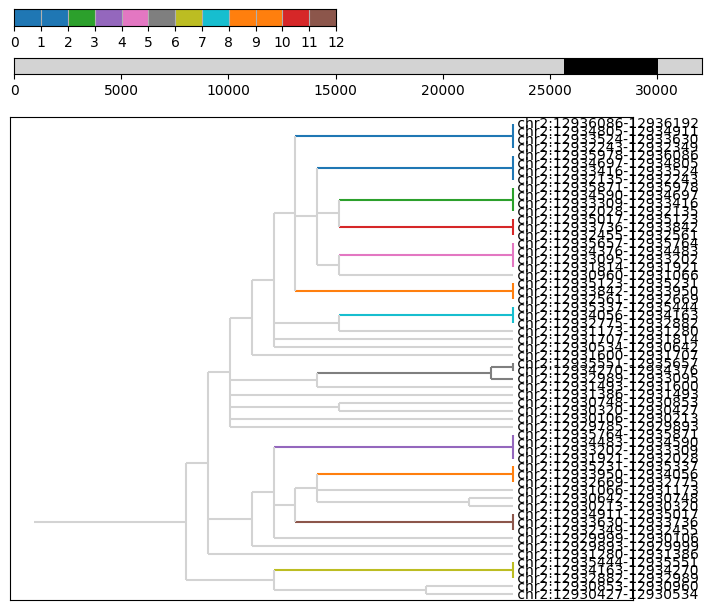

In [15]:
show_hor_tree(hor_tree_root, tree)

None


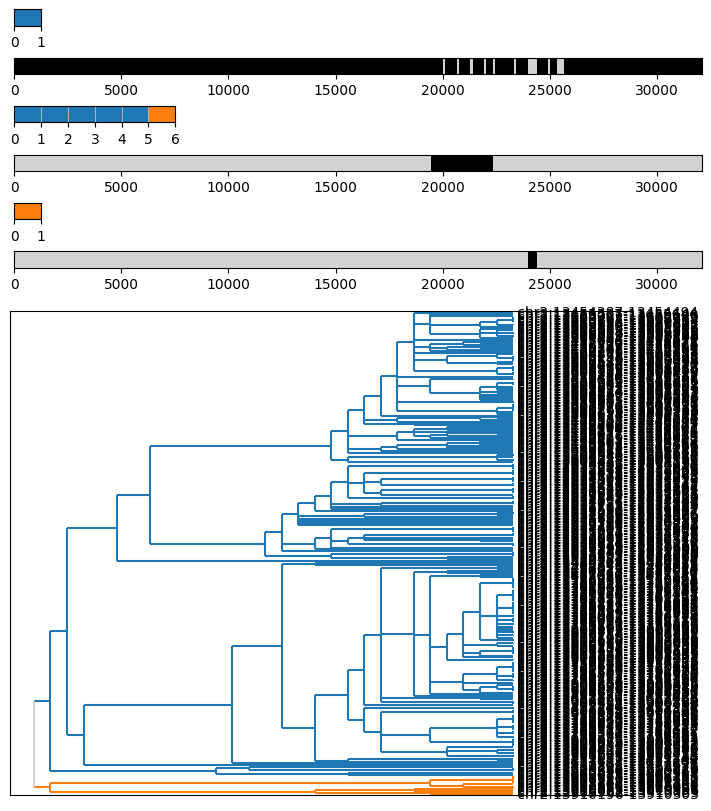

In [16]:
show_hors(hor_tree_root.sub_hors, tree)

In [17]:
actual_hors = [hor for hor in hors if len(hor.hor.clade_seq) > 1]

In [18]:
tree_output_filename = f'data/vitis/clusterings/test.tree.xml'
Phylo.write(new_phyloXML([tree]), tree_output_filename, format='phyloxml')

1